<a href="https://colab.research.google.com/github/somebodyawesome-dev/movie-mapper/blob/master/recommendation-engine/movie_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#import librairies
import numpy as np
import pandas as pd
import nltk
import pickle 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asmaa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asmaa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\asmaa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\asmaa\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\asmaa\AppData\Roaming\nltk_data...


True

In [7]:
#upload dataset
#from google.colab import files
#uploaded = files.upload()

Saving movie-dataset.csv to movie-dataset.csv


In [5]:
#store data
data=pd.read_json('movie-mapper.movie-dataset.json')
data.head()

,_id,imdbId,title,plot,poster,year,runtime,language,country,cast,genres
0,{'$oid': '620b3d591b78ad2bfc739b72'},tt0204946,Bring It On,The Toro cheerleading squad from Rancho Carne ...,https://m.media-amazon.com/images/M/MV5BNjhiMj...,2000,98 min,English,United States,"[Kirsten Dunst, Eliza Dushku, Jesse Bradford]","[Comedy, Romance, Sport]"
1,{'$oid': '620b3d5c1b78ad2bfc739b7a'},tt0218839,Best in Show,"At the prestigious Mayflower Dog Show, a ""docu...",https://m.media-amazon.com/images/M/MV5BMTQ5OT...,2000,90 min,English,United States,"[Fred Willard, Eugene Levy, Catherine O'Hara]",[Comedy]
2,{'$oid': '620b3d601b78ad2bfc739b86'},tt0175142,Scary Movie,A group of teenagers including Cindy Campbell ...,https://m.media-amazon.com/images/M/MV5BMGEzZj...,2000,88 min,English,United States,"[Anna Faris, Jon Abrahams, Marlon Wayans]",[Comedy]
3,{'$oid': '620b3d611b78ad2bfc739b8b'},tt0190590,"O Brother, Where Art Thou?","Loosely based on Homer's ""Odyssey,"" the movie ...",https://m.media-amazon.com/images/M/MV5BMjZkOT...,2000,107 min,English,"United Kingdom, France, United States","[George Clooney, John Turturro, Tim Blake Nelson]","[Comedy, Adventure, Crime]"
4,{'$oid': '620b3d631b78ad2bfc739b91'},tt0210945,Remember the Titans,Suburban Virginia schools have been segregated...,https://m.media-amazon.com/images/M/MV5BYThkMz...,2000,113 min,English,United States,"[Denzel Washington, Will Patton, Wood Harris]","[Sport, Drama, Biography]"


In [6]:
# get the dimension of the dataset
data.shape


(17277, 11)

In [7]:
#extract important columns
columns= ['cast','genres','language','plot','title']
data[columns].head(3)


,cast,genres,language,plot,title
0,"[Kirsten Dunst, Eliza Dushku, Jesse Bradford]","[Comedy, Romance, Sport]",English,The Toro cheerleading squad from Rancho Carne ...,Bring It On
1,"[Fred Willard, Eugene Levy, Catherine O'Hara]",[Comedy],English,"At the prestigious Mayflower Dog Show, a ""docu...",Best in Show
2,"[Anna Faris, Jon Abrahams, Marlon Wayans]",[Comedy],English,A group of teenagers including Cindy Campbell ...,Scary Movie


# Analyse Movie Languages

In [9]:
np.unique(data['language'].astype(str))

array(['Afrikaans', 'Afrikaans, English', 'Afrikaans, English, Ungwatsi',
       ..., 'Zulu, English', 'Zulu, English, Sotho, Tswana',
       'Zulu, Sotho, Xhosa, Afrikaans, English'], dtype=object)

In [11]:
len(data.loc[data['language']=='English'])

9157

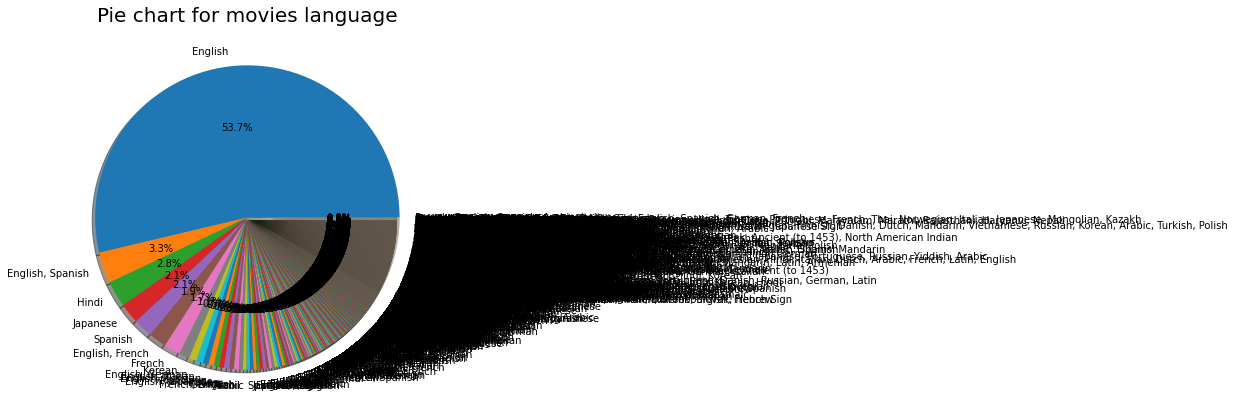

In [9]:
#import matplotlib.pyplot as plt
#fig = plt.figure(figsize=(10,7))
#plt.title("Pie chart for movies language",fontsize=20)
#percen = data['language'].value_counts()
#plt.pie(percen, labels=percen.index, autopct='%1.1f%%', shadow=True)
#plt.show()

In [12]:
#check for null values
data=data.dropna(how='any',axis=0)
#data=data.dropna(how='any',subset=columns,axis=0)

data.shape



(17277, 11)

# Tokenizing and preprocessing data

In [14]:
#hamza tach
#tokenizing and preprocessing data
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
  
VERB_CODES = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}
def preprocess_sentences(text):
  text = text.lower()
  temp_sent =[]
  words = nltk.word_tokenize(text)
  tags = nltk.pos_tag(words)
  for i, word in enumerate(words):
      if tags[i][1] in VERB_CODES: 
          lemmatized = lemmatizer.lemmatize(word, 'v')
      else:
          lemmatized = lemmatizer.lemmatize(word)
      if lemmatized not in stop_words and lemmatized.isalpha():
          temp_sent.append(lemmatized)
          
  finalsent = ' '.join(temp_sent)
  finalsent = finalsent.replace("n't", " not")
  finalsent = finalsent.replace("'m", " am")
  finalsent = finalsent.replace("'s", " is")
  finalsent = finalsent.replace("'re", " are")
  finalsent = finalsent.replace("'ll", " will")
  finalsent = finalsent.replace("'ve", " have")
  finalsent = finalsent.replace("'d", " would")
  return finalsent
  
data["plot_processed"]= data["plot"].apply(preprocess_sentences)
data.head(3)

,_id,imdbId,title,plot,poster,year,runtime,language,country,cast,genres,plot_processed
0,{'$oid': '620b3d591b78ad2bfc739b72'},tt0204946,Bring It On,The Toro cheerleading squad from Rancho Carne ...,https://m.media-amazon.com/images/M/MV5BNjhiMj...,2000,98 min,English,United States,"[Kirsten Dunst, Eliza Dushku, Jesse Bradford]","[Comedy, Romance, Sport]",toro cheerlead squad rancho carne high school ...
1,{'$oid': '620b3d5c1b78ad2bfc739b7a'},tt0218839,Best in Show,"At the prestigious Mayflower Dog Show, a ""docu...",https://m.media-amazon.com/images/M/MV5BMTQ5OT...,2000,90 min,English,United States,"[Fred Willard, Eugene Levy, Catherine O'Hara]",[Comedy],prestigious mayflower dog show documentary fil...
2,{'$oid': '620b3d601b78ad2bfc739b86'},tt0175142,Scary Movie,A group of teenagers including Cindy Campbell ...,https://m.media-amazon.com/images/M/MV5BMGEzZj...,2000,88 min,English,United States,"[Anna Faris, Jon Abrahams, Marlon Wayans]",[Comedy],group teenager include cindy campbell bobby pr...


# Recommendtion function

In [ ]:
#mariem tach
#make recommendtion function

### Cosine Similarity

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorizing pre-processed movie plots using TF-IDF
tfidfvec = TfidfVectorizer()
tfidf_movieid = tfidfvec.fit_transform((data["plot_processed"]))
# Finding cosine similarity between vectors
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = cosine_similarity(tfidf_movieid, tfidf_movieid)

### recommendation function

In [17]:
finaldata = data[["title", "plot_processed"]]          # Required columns - Title and movie plot
finaldata = finaldata.set_index('title')    # Setting the movie title as index

In [19]:
# Storing indices of the data
indices = pd.Series(finaldata.index)

def recommendations(title, cosine_sim = cos_sim):
	recommended_movies = []
	index = indices[indices == title].index[0]
	similarity_scores = pd.Series(cosine_sim[index]).sort_values(ascending = False)
	top = list(similarity_scores.iloc[0:21].index)
	for i in top:
		recommended_movies.append(list(finaldata.index)[i])
	return recommended_movies




### Test

In [20]:
movies =recommendations("Superman")
movies

['Superman',
 'Superman II',
 'Justice League: Crisis on Two Earths',
 'Batman v Superman: Dawn of Justice',
 'Superman Returns',
 'Superman/Batman: Public Enemies',
 'All-Star Superman',
 'Superman III',
 'Power Rangers Ninja Steel',
 'Superman vs. The Elite',
 'Malicious',
 "National Lampoon's Christmas Vacation",
 'Zion',
 'Head Above Water',
 'Superman IV: The Quest for Peace',
 "National Lampoon's Vacation",
 'Love Comes Softly',
 'Lea to the Rescue',
 'Supergirl',
 'Welcome to the Rileys',
 'The Death of Superman']

In [ ]:
import math
import json

In [21]:
# GET /recommend 
req = json.loads(REQUEST)
args = req['args']
print(json.dumps({'movies': recommendations(args['movie'][0])}))

NameError: name 'json' is not defined

Save Model Using into fil using Pickle

In [22]:
with open('model_pickle','wb') as f:
    pickle.dump(movies, f)
with open('model_pickle', 'rb') as f : 
    mp=pickle.load(f)
    


Testing the model saving in fils 

In [ ]:
#jupyter kernelgateway --KernelGatewayApp.api='kernel_gateway.notebook_http' --KernelGatewayApp.seed_uri='movie_recommendation.ipynb' --KernelGatewayApp.allow_origin='*'
#pip install --no-cache-dir jupyter_kernel_gateway
#jupyter kernelgateway --generate-config